In [92]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import librosa
import librosa.display
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

import math
import random
import seaborn as sns
from tqdm import tqdm
from scipy import stats

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = 'id_00'  

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

sns.set(style='whitegrid')


In [93]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model: int, input_dim: int):
        super().__init__()
        self.d_model = d_model
        self.linear = nn.Linear(input_dim, d_model)
            
    def forward(self, x):
        return self.linear(x) * math.sqrt(self.d_model)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, seq_len: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(seq_len, d_model)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) 
        pe[:, 1::2] = torch.cos(position * div_term) 
        pe = pe.unsqueeze(0) 
        self.register_buffer('pe', pe)
            
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return self.dropout(x)

class LayerNormalization(nn.Module):
    def __init__(self, features: int, eps: float = 1e-6) -> None:
        super().__init__()
        self.layer_norm = nn.LayerNorm(features, eps=eps)
            
    def forward(self, x):
        return self.layer_norm(x)

class ResidualConnection(nn.Module):
    def __init__(self, features: int, dropout: float) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.norm = LayerNormalization(features)
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.linear_1 = nn.Linear(d_model, d_ff) 
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) 

    def forward(self, x):
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x))))

class MultiHeadAttentionBlock(nn.Module):
    def __init__(self, d_model: int, h: int, dropout: float) -> None:
        super().__init__()
        self.multihead_attn = nn.MultiheadAttention(embed_dim=d_model, num_heads=h, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, query, key, value, mask=None):
        attn_output, attn_weights = self.multihead_attn(query, key, value, key_padding_mask=mask)
        return self.dropout(attn_output)

class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.feed_forward = FeedForwardBlock(d_model, d_ff, dropout)
        self.residual1 = ResidualConnection(d_model, dropout)
        self.residual2 = ResidualConnection(d_model, dropout)

    def forward(self, src, src_mask):
        src = self.residual1(src, lambda x: self.self_attn(x, x, x, mask=src_mask))
        src = self.residual2(src, self.feed_forward)
        return src

class DecoderLayer(nn.Module):
    def __init__(self, d_model: int, h: int, d_ff: int, dropout: float) -> None:
        super().__init__()
        self.self_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.cross_attn = MultiHeadAttentionBlock(d_model, h, dropout)
        self.feed_forward = FeedForwardBlock(d_model, d_ff, dropout)
        self.residual1 = ResidualConnection(d_model, dropout)
        self.residual2 = ResidualConnection(d_model, dropout)
        self.residual3 = ResidualConnection(d_model, dropout)

    def forward(self, tgt, memory, src_mask, tgt_mask):
        tgt = self.residual1(tgt, lambda x: self.self_attn(x, x, x, mask=tgt_mask))
        tgt = self.residual2(tgt, lambda x: self.cross_attn(x, memory, memory, mask=src_mask))
        tgt = self.residual3(tgt, self.feed_forward)
        return tgt

class Encoder(nn.Module):
    def __init__(self, encoder_layer, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])
        self.norm = LayerNormalization(encoder_layer.self_attn.multihead_attn.embed_dim)

    def forward(self, src, src_mask):
        for layer in self.layers:
            src = layer(src, src_mask)
        return self.norm(src)

class Decoder(nn.Module):
    def __init__(self, decoder_layer, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])
        self.norm = LayerNormalization(decoder_layer.self_attn.multihead_attn.embed_dim)

    def forward(self, tgt, memory, src_mask, tgt_mask):
        for layer in self.layers:
            tgt = layer(tgt, memory, src_mask, tgt_mask)
        return self.norm(tgt)

class Transformer(nn.Module):
    def __init__(self, 
                 input_dim: int, 
                 d_model: int, 
                 num_layers: int, 
                 num_heads: int, 
                 d_ff: int, 
                 dropout: float, 
                 seq_len: int):
        super().__init__()
        self.encoder_embedding = InputEmbeddings(d_model, input_dim)
        self.encoder_pos = PositionalEncoding(d_model, seq_len, dropout)
        encoder_layer = EncoderLayer(d_model, num_heads, d_ff, dropout)
        self.encoder = Encoder(encoder_layer, num_layers)

        self.decoder_embedding = InputEmbeddings(d_model, input_dim)
        self.decoder_pos = PositionalEncoding(d_model, seq_len, dropout)
        decoder_layer = DecoderLayer(d_model, num_heads, d_ff, dropout)
        self.decoder = Decoder(decoder_layer, num_layers)

        self.output_layer = nn.Linear(d_model, input_dim)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src = self.encoder_embedding(src)  
        src = self.encoder_pos(src)        
        memory = self.encoder(src, src_mask)  

        tgt = self.decoder_embedding(tgt)  
        tgt = self.decoder_pos(tgt)        
        output = self.decoder(tgt, memory, src_mask, tgt_mask)  

        output = self.output_layer(output)  
        return output


In [94]:
class WavDataset(Dataset):
    def __init__(self, file_paths, labels=None, seq_len=128, n_mfcc=40, return_labels=False):
        """
        file_paths: lista de caminhos para os arquivos .wav
        labels: lista de labels (0 para normal, 1 para anormal). Necessário se return_labels=True
        seq_len: comprimento da sequência (número de frames)
        n_mfcc: número de coeficientes MFCC a serem extraídos
        return_labels: se True, retorna (dados, rótulos). Caso contrário, retorna (dados, dados)
        """
        self.file_paths = file_paths
        self.labels = labels
        self.seq_len = seq_len
        self.n_mfcc = n_mfcc
        self.return_labels = return_labels
        self.scaler = StandardScaler()

        # Pré-processar todos os dados e armazenar
        self.data = []
        for path in tqdm(self.file_paths, desc="Pré-processando arquivos"):
            mfcc = self.extract_mfcc(path)
            self.data.append(mfcc)
        
        # Converter para array numpy
        self.data = np.array(self.data)

        # Normalizar os dados
        self.data = self.data.reshape(-1, self.n_mfcc)
        self.data = self.scaler.fit_transform(self.data)
        self.data = self.data.reshape(-1, self.seq_len, self.n_mfcc)
    
    def extract_mfcc(self, file_path):
        y, sr = librosa.load(file_path, sr=None)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=self.n_mfcc)
        if mfcc.shape[1] < self.seq_len:
            pad_width = self.seq_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0,0),(0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :self.seq_len]
        return mfcc.T  # (seq_len, n_mfcc)
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        if self.return_labels:
            label = self.labels[idx]
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor([label])
        else:
            return torch.FloatTensor(self.data[idx]), torch.FloatTensor(self.data[idx])


In [95]:
import random

# Função para listar arquivos .wav e seus labels
def get_file_paths_and_labels(data_path):
    normal_dir = os.path.join(data_path, 'normal')
    abnormal_dir = os.path.join(data_path, 'abnormal')
    
    normal_paths = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith('.wav')]
    abnormal_paths = [os.path.join(abnormal_dir, f) for f in os.listdir(abnormal_dir) if f.endswith('.wav')]
    
    normal_labels = [0]*len(normal_paths)
    abnormal_labels = [1]*len(abnormal_paths)
    
    return normal_paths, normal_labels, abnormal_paths, abnormal_labels

normal_paths, normal_labels, abnormal_paths, abnormal_labels = get_file_paths_and_labels(DATA_PATH)

print(f"Total de arquivos normais: {len(normal_paths)}")
print(f"Total de arquivos anômalos: {len(abnormal_paths)}")

train_paths = normal_paths  # Treinar apenas com dados normais
train_labels = normal_labels  

# Teste com 100 exemplos, com proporção aleatória de normais e anormais
num_test_examples = 100

combined_test_paths = normal_paths + abnormal_paths
combined_test_labels = normal_labels + abnormal_labels

test_indices = random.sample(range(len(combined_test_paths)), num_test_examples)
test_paths = [combined_test_paths[i] for i in test_indices]
test_labels = [combined_test_labels[i] for i in test_indices]

print(f"Total de arquivos no treinamento: {len(train_paths)}")
print(f"Total de arquivos no teste: {len(test_paths)}")

train_dataset = WavDataset(train_paths, labels=None, return_labels=False)
test_dataset = WavDataset(test_paths, labels=test_labels, return_labels=True)

print(f"Formato de uma amostra de treinamento: {train_dataset[0][0].shape}")
print(f"Formato de uma amostra de teste: {test_dataset[0][0].shape}")

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Tamanho do DataLoader de treinamento: {len(train_loader)} batches")
print(f"Tamanho do DataLoader de teste: {len(test_loader)} batches")


Total de arquivos normais: 100
Total de arquivos anômalos: 100
Total de arquivos no treinamento: 100
Total de arquivos no teste: 100


Pré-processando arquivos: 100%|██████████| 100/100 [00:01<00:00, 74.38it/s]

Formato de uma amostra de treinamento: torch.Size([128, 40])
Formato de uma amostra de teste: torch.Size([128, 40])
Tamanho do DataLoader de treinamento: 7 batches
Tamanho do DataLoader de teste: 7 batches


In [96]:
# Parâmetros do Modelo
INPUT_DIM = 40  # Número de coeficientes MFCC
D_MODEL = 512
NUM_LAYERS = 4
NUM_HEADS = 8
D_FF = 512
DROPOUT = 0.1
SEQ_LEN = 128

print("Inicializando o modelo Transformer com os seguintes parâmetros:")
print(f"Input Dim: {INPUT_DIM}")
print(f"D_Model: {D_MODEL}")
print(f"Number of Layers: {NUM_LAYERS}")
print(f"Number of Heads: {NUM_HEADS}")
print(f"D_FF: {D_FF}")
print(f"Dropout: {DROPOUT}")
print(f"Sequence Length: {SEQ_LEN}")

# Inicializar o modelo
model = Transformer(input_dim=INPUT_DIM, 
                    d_model=D_MODEL, 
                    num_layers=NUM_LAYERS, 
                    num_heads=NUM_HEADS, 
                    d_ff=D_FF, 
                    dropout=DROPOUT, 
                    seq_len=SEQ_LEN).to(DEVICE)

print(f"Modelo está na {DEVICE}")

# Função de perda e otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

print("Função de perda e otimizador definidos.")


Inicializando o modelo Transformer com os seguintes parâmetros:
Input Dim: 40
D_Model: 512
Number of Layers: 4
Number of Heads: 8
D_FF: 512
Dropout: 0.1
Sequence Length: 128
Modelo está na cpu
Função de perda e otimizador definidos.


Iniciando o treinamento do modelo...


Epoch 1/50, Training Loss: 0.967939
Epoch 5/50, Training Loss: 0.376958
Epoch 10/50, Training Loss: 0.234068
Epoch 15/50, Training Loss: 0.143571
Epoch 20/50, Training Loss: 0.094562
Epoch 25/50, Training Loss: 0.070733
Epoch 30/50, Training Loss: 0.055696
Epoch 35/50, Training Loss: 0.045788
Epoch 40/50, Training Loss: 0.038665
Epoch 45/50, Training Loss: 0.033156
Epoch 50/50, Training Loss: 0.028873


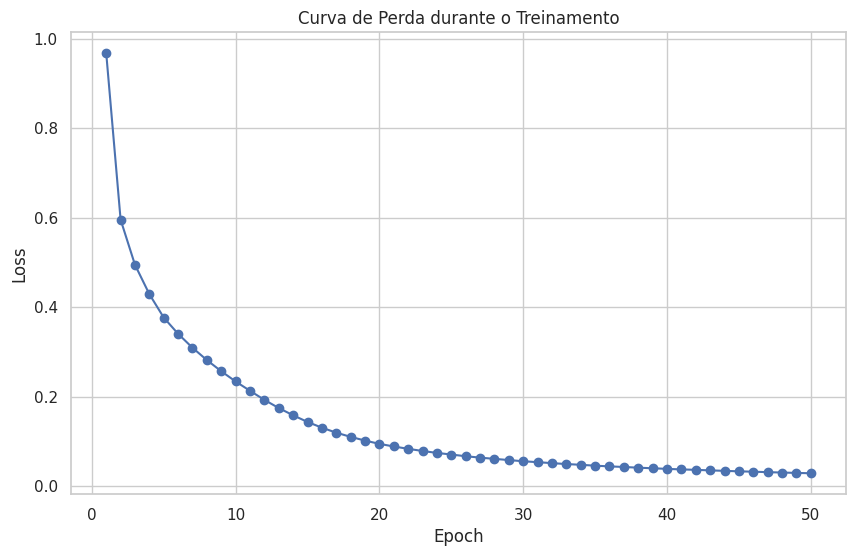

In [97]:
EPOCHS = 50
train_losses = []

print("Iniciando o treinamento do modelo...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        
        optimizer.zero_grad()
        
        outputs = model(inputs, inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    if (epoch+1) % 5 == 0 or epoch == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Training Loss: {train_loss:.6f}')

# Plotar a curva de perda
plt.figure(figsize=(10,6))
plt.plot(range(1, EPOCHS+1), train_losses, marker='o')
plt.title('Curva de Perda durante o Treinamento')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


Iniciando a avaliação do modelo...


Avaliando: 100%|██████████| 7/7 [00:00<00:00,  7.08it/s]


Reconstruction Errors Shape: (100,)
Labels Shape: (100, 1)

Resultados da Avaliação:
AUC: 0.7515
Precision: 1.0000
Recall: 0.1111
F1-Score: 0.2000


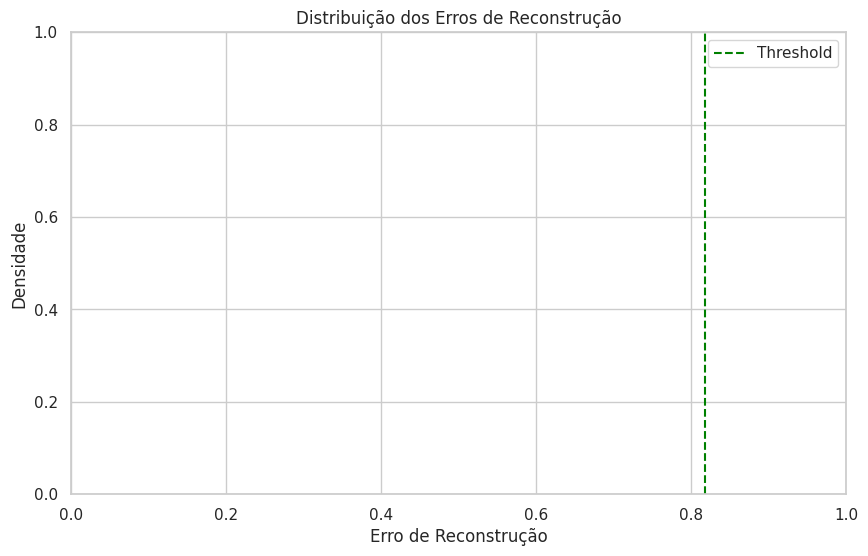

In [98]:
model.eval()
reconstruction_errors = []
labels = []

print("Iniciando a avaliação do modelo...")

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Avaliando"):
        inputs, batch_labels = batch  
        inputs = inputs.to(DEVICE)
        outputs = model(inputs, inputs)
        loss = torch.mean((outputs - inputs)**2, dim=[1,2]) 
        reconstruction_errors.extend(loss.cpu().numpy())
        labels.extend(batch_labels.numpy()) 

print(f"Reconstruction Errors Shape: {np.array(reconstruction_errors).shape}")
print(f"Labels Shape: {np.array(labels).shape}")

errors = np.array(reconstruction_errors)
errors = (errors - errors.min()) / (errors.max() - errors.min())

threshold = np.percentile(errors, 95)  

preds = (errors > threshold).astype(int)

auc = roc_auc_score(labels, errors)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')

print(f'\nResultados da Avaliação:')
print(f'AUC: {auc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

# Plotar a distribuição de erros
plt.figure(figsize=(10,6))
sns.histplot(errors[labels==0], bins=50, kde=True, color='blue', label='Normal', stat='density', alpha=0.6)
sns.histplot(errors[labels==1], bins=50, kde=True, color='red', label='Anômalo', stat='density', alpha=0.6)
plt.axvline(threshold, color='green', linestyle='--', label='Threshold')
plt.xlabel('Erro de Reconstrução')
plt.ylabel('Densidade')
plt.title('Distribuição dos Erros de Reconstrução')
plt.legend()
plt.show()


Índice da amostra normal: 46, Label: [0.]


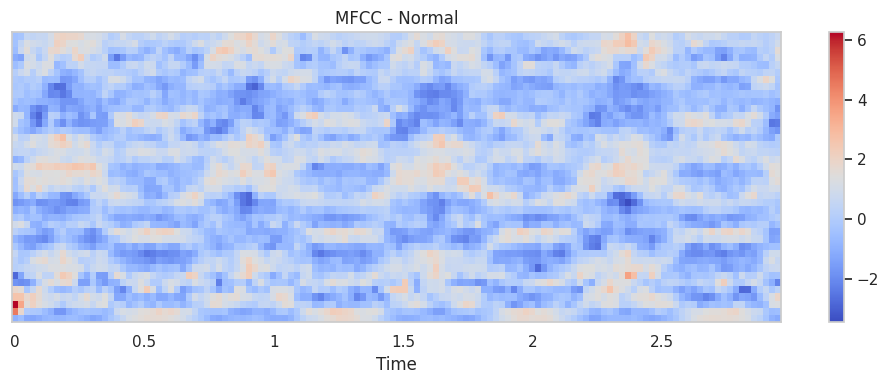

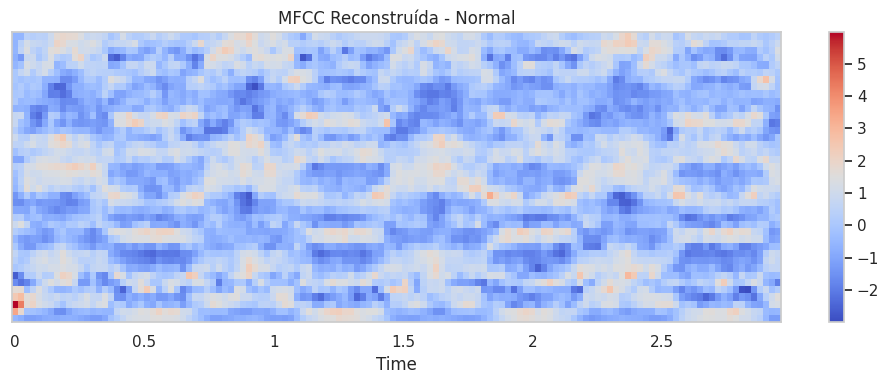

Índice da amostra anômala: 36, Label: [1.]


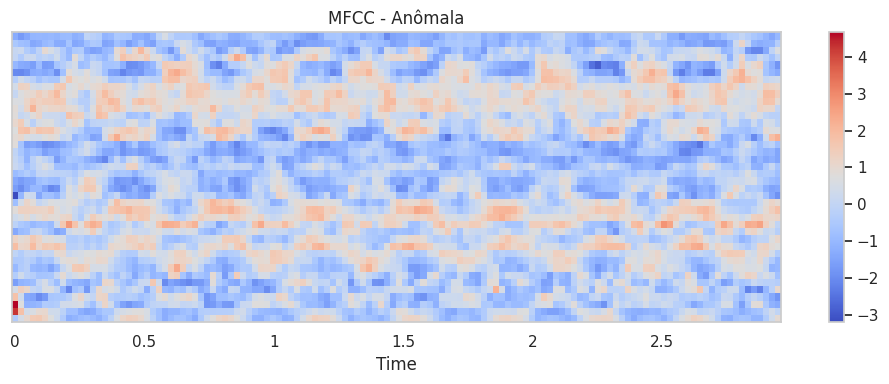

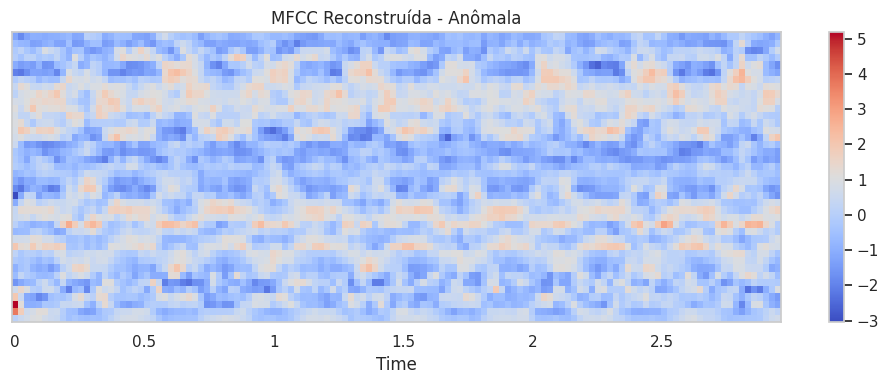

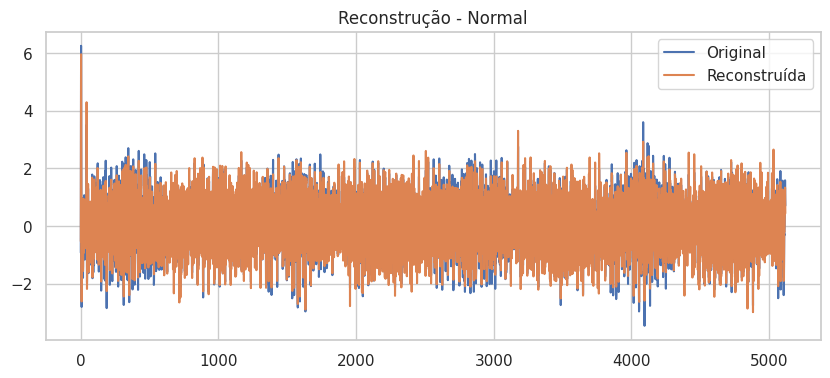

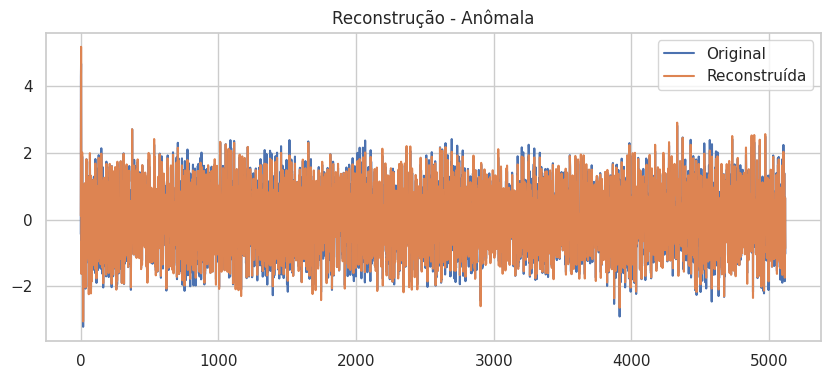

In [99]:
# Selecionar exemplos: uma normal e uma anômala
normal_indices = [i for i, label in enumerate(labels) if label == 0]
anomalous_indices = [i for i, label in enumerate(labels) if label == 1]

# Selecionar uma normal e uma anômala
normal_idx = random.choice(normal_indices)
anomalous_idx = random.choice(anomalous_indices)

def plot_mfcc(mfcc, title="MFCC"):
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfcc, x_axis='time')
    plt.colorbar()
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_reconstruction(original, reconstructed, title="Reconstrução"):
    plt.figure(figsize=(10,4))
    plt.plot(original.flatten(), label='Original')
    plt.plot(reconstructed.flatten(), label='Reconstruída')
    plt.title(title)
    plt.legend()
    plt.show()

# Função para obter a amostra e reconstrução
def get_sample(idx):
    data, label = test_dataset[idx]
    data = data.unsqueeze(0).to(DEVICE)  # Adicionar dimensão batch
    with torch.no_grad():
        reconstruction = model(data, data).cpu().squeeze(0)
    return data.cpu().squeeze(0).numpy(), reconstruction.numpy(), labels[idx]

# Normal
normal_data, normal_recon, normal_label = get_sample(normal_idx)
print(f"Índice da amostra normal: {normal_idx}, Label: {normal_label}")
plot_mfcc(normal_data.T, title="MFCC - Normal")
plot_mfcc(normal_recon.T, title="MFCC Reconstruída - Normal")

# Anômala
anomalous_data, anomalous_recon, anomalous_label = get_sample(anomalous_idx)
print(f"Índice da amostra anômala: {anomalous_idx}, Label: {anomalous_label}")
plot_mfcc(anomalous_data.T, title="MFCC - Anômala")
plot_mfcc(anomalous_recon.T, title="MFCC Reconstruída - Anômala")

# Plotar Reconstrução vs Original
plot_reconstruction(normal_data, normal_recon, title="Reconstrução - Normal")
plot_reconstruction(anomalous_data, anomalous_recon, title="Reconstrução - Anômala")


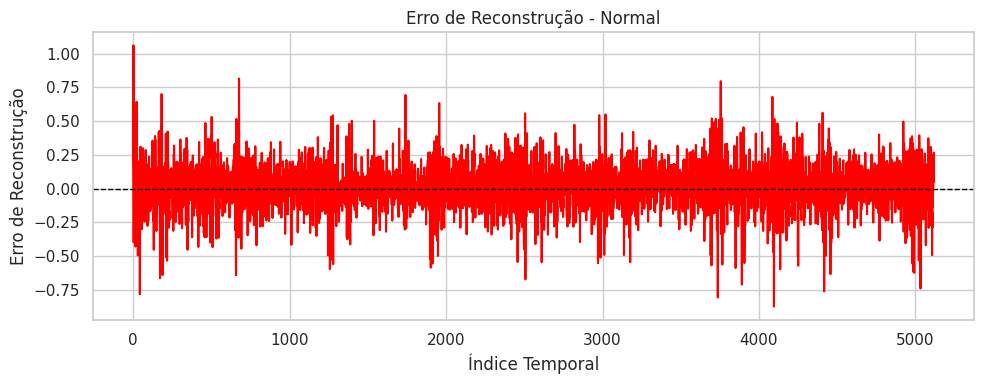

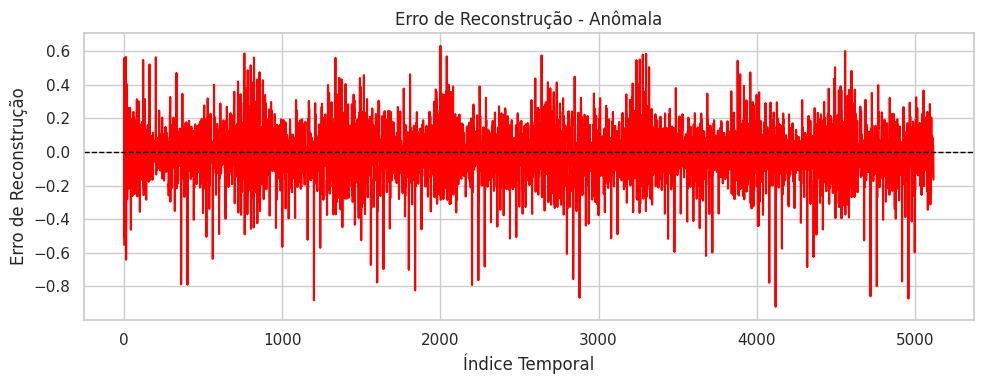

In [100]:
def plot_reconstruction_error(original, reconstructed, title="Erro de Reconstrução"):
    # Calcula a diferença (erro) entre o original e o reconstruído
    reconstruction_error = original.flatten() - reconstructed.flatten()
    
    # Plotar o erro
    plt.figure(figsize=(10,4))
    plt.plot(reconstruction_error, color='red')
    plt.title(title)
    plt.xlabel('Índice Temporal')
    plt.ylabel('Erro de Reconstrução')
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

# Plotar Erro de Reconstrução para Normal e Anômala
plot_reconstruction_error(normal_data, normal_recon, title="Erro de Reconstrução - Normal")
plot_reconstruction_error(anomalous_data, anomalous_recon, title="Erro de Reconstrução - Anômala")


/tmp/ipykernel_23489/3326563925.py:19: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  labels = np.array(labels)
/tmp/ipykernel_23489/3326563925.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  labels = np.array(labels)


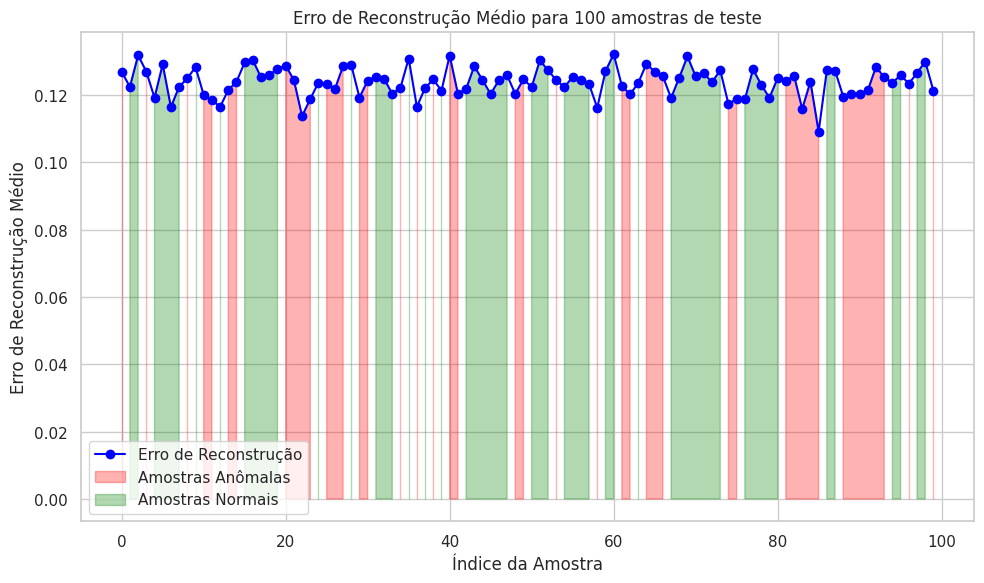

In [101]:
def calculate_reconstruction_error(original, reconstructed):
    return np.mean(np.abs(original.flatten() - reconstructed.flatten()))

errors = []
labels = []

for idx in range(len(test_dataset)):
    data, label = test_dataset[idx]
    data = data.unsqueeze(0).to(DEVICE) 
    with torch.no_grad():
        reconstruction = model(data, data).cpu().squeeze(0)
    
    error = calculate_reconstruction_error(data.cpu().squeeze(0).numpy(), reconstruction.numpy())
    
    errors.append(error)
    labels.append(label)

errors = np.array(errors)
labels = np.array(labels)

# Plotar erro de reconstrução para todas as amostras
plt.figure(figsize=(10,6))
plt.plot(errors, label="Erro de Reconstrução", marker='o', linestyle='-', color='blue')
plt.fill_between(range(len(errors)), 0, errors, where=labels == 1, color='red', alpha=0.3, label="Amostras Anômalas")
plt.fill_between(range(len(errors)), 0, errors, where=labels == 0, color='green', alpha=0.3, label="Amostras Normais")

plt.title('Erro de Reconstrução Médio para 100 amostras de teste')
plt.xlabel('Índice da Amostra')
plt.ylabel('Erro de Reconstrução Médio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
